# Linear Regression using the close's price of Bitcoin and Ethereum between the begin of this year (2022) until november 30th of the same year.

In [68]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import scale

%matplotlib inline

In [4]:
# Fetch the lis of exchanges
resp = requests.get('https://api.cryptowat.ch/exchanges')

In [5]:
# Get list of exchange values you can use
exchange_names = [e['symbol'] for e in resp.json()['result'] \
                  if e['active']]
print(exchange_names)

['bitfinex', 'coinbase-pro', 'bitstamp', 'kraken', 'cexio', 'gemini', 'liquid', 'bitflyer', 'okcoin', 'bitmex', 'huobi', 'luno', 'poloniex', 'bisq', 'bithumb', 'bittrex', 'binance', 'zonda', 'okx', 'coinone', 'hitbtc', 'gateio', 'binance-us', 'kraken-futures', 'ftx', 'deribit', 'cme', 'uniswap-v2', 'ftx-us', 'comex', 'nymex', 'kucoin', 'bybit', 'crypto-com']


In [6]:
# Select Binance
selected_exchange = 'binance'

# Fetch markets on the exchange
exchange_resp = requests.get(f'https://api.cryptowat.ch/markets/{selected_exchange}')


In [8]:
# See all the pairs in the market
pairs = [i['pair'] for i in exchange_resp.json()['result'] \
         if i['active']]

# I have needed to search the pair, cause the output was giving an error
for i in pairs:
    if i == 'btcusdt':
        print(i)


btcusdt


In [9]:
# Data Parameters
start_date = '12/8/2021'
end_date = '1/8/2022'
period = 86400 # Time period in seconds (86400 = 1 day)

In [10]:
# Convert the dates to timestamps
from datetime import datetime

def to_timestamp(dateString):
    element = datetime.strptime(dateString, '%m/%d/%Y')
    return int(datetime.timestamp(element))

# Will be used later to convert back
def to_date(timestamp):
    dt = datetime.fromtimestamp(timestamp)
    return dt.strftime('%m/%d?%Y')

start_ts = to_timestamp(start_date)
end_ts = to_timestamp(end_date)

In [11]:
# Fetch the data

pair = 'ethusdt'

params = {
    'after': start_ts,
    'before': end_ts,
    'periods':period
}

ohlc_resp = requests.get(f'https://api.cryptowat.ch/markets/{selected_exchange}/{pair}/ohlc', params=params)
#ohlc_resp.json()['result'][f'{period}']

In [12]:
# Putting this codes above in a function

def get_crypto_api(exchange, pair, start_date, end_date, period):
    from datetime import datetime

    def to_timestamp(dateString):
        element = datetime.strptime(dateString, '%m/%d/%Y')
        return int(datetime.timestamp(element))
    
    start_ts = to_timestamp(start_date)
    end_ts = to_timestamp(end_date)
    
    params = {
    'after': start_ts,
    'before': end_ts,
    'periods':period
    }
    
    ohlc_resp = requests.get(f'https://api.cryptowat.ch/markets/{exchange}/{pair}/ohlc', params=params)
    
    # Convert timestamp to date object in each row
    data = [tuple([datetime.fromtimestamp(i[0])] + i[1:]) for i in ohlc_resp.json()['result'][f'{period}']]
    
    # Create dataframe
    columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'qt_volume']
    
    df = pd.DataFrame.from_records(data, columns=columns)
    df.set_index('date', inplace=True)
    
    return df

In [13]:
# Testing the function
test = get_crypto_api('binance', 'ethusdt', '12/8/2021', '1/8/2022', 86400)

test.head()

,open,high,low,close,volume,qt_volume
date,,,,,,
2021-12-08 21:00:00,4306.40,4450.49,4222.95,4436.91,429403.9351,1.868281e+09
2021-12-09 21:00:00,4436.91,4488.00,4076.16,4105.64,462173.7110,1.970733e+09
2021-12-10 21:00:00,4105.64,4231.08,3887.37,3897.94,563236.5671,2.287155e+09
2021-12-11 21:00:00,3898.31,4097.08,3828.22,4089.37,427853.4343,1.711893e+09
2021-12-12 21:00:00,4089.68,4173.63,3986.25,4130.00,260535.5157,1.061362e+09


In [14]:
# Getting the biction's price of this year

btc = get_crypto_api('binance', 'btcusdt', '1/1/2022', '11/30/2022', 86400)

btc.head()

,open,high,low,close,volume,qt_volume
date,,,,,,
2022-01-01 21:00:00,46216.93,47954.63,46208.37,47722.65,19604.46325,9.241552e+08
2022-01-02 21:00:00,47722.66,47990.00,46654.00,47286.18,18340.46040,8.666110e+08
2022-01-03 21:00:00,47286.18,47570.00,45696.00,46446.10,27662.07710,1.292204e+09
2022-01-04 21:00:00,46446.10,47557.54,45500.00,45832.01,35491.41360,1.649170e+09
2022-01-05 21:00:00,45832.01,47070.00,42500.00,43451.13,51784.11857,2.334289e+09


In [15]:
btc.describe()

,open,high,low,close,volume,qt_volume
count,333.000000,333.000000,333.000000,333.000000,333.000000,3.330000e+02
mean,29354.399309,30025.544985,28554.610871,29265.009550,142136.966905,3.289248e+09
std,10041.164921,10263.973538,9794.846982,10023.112339,125247.115050,2.210450e+09
min,15781.290000,16315.000000,15476.000000,15781.290000,15805.447180,6.161947e+08
25%,20173.620000,20576.250000,19652.720000,20158.260000,46275.669120,1.711653e+09
50%,24305.250000,24918.540000,23773.220000,24094.820000,91904.753211,2.556533e+09
75%,39530.450000,40444.320000,38536.510000,39450.130000,210509.495450,4.294908e+09
max,47722.660000,48189.840000,46950.850000,47722.650000,760705.362783,1.475838e+10


In [16]:
# Searching NaN values
btc.isnull().values.any()

False

<AxesSubplot: xlabel='date'>

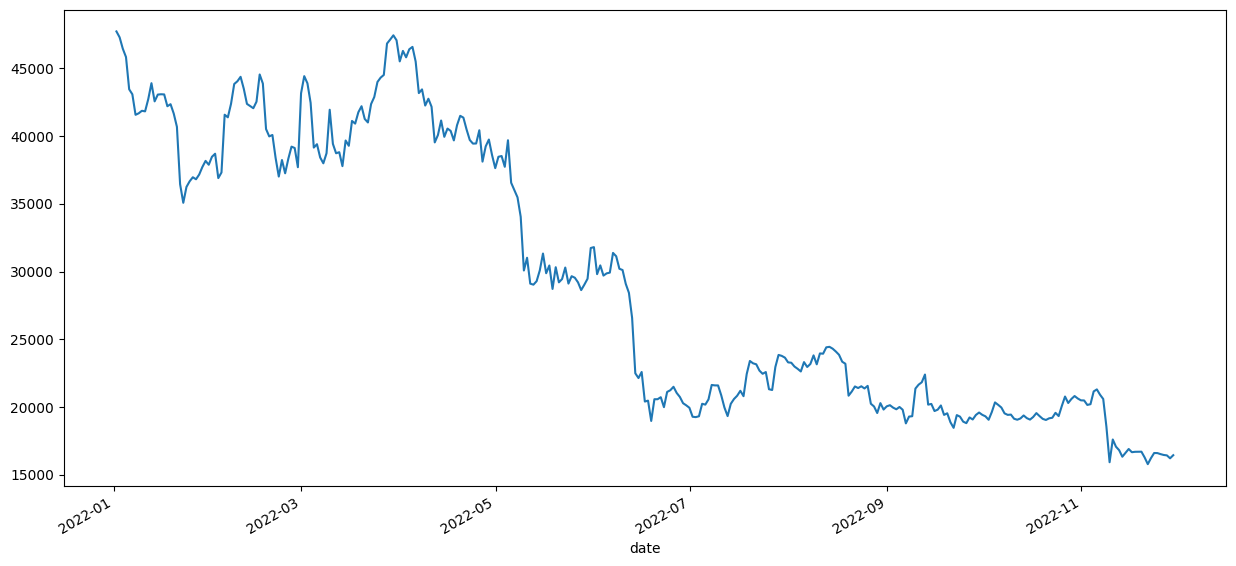

In [18]:
# Searching outliers in the dataframe

btc['close'].plot(figsize=(15,7))

In [19]:
# Getting the ethereum's price of this year
eth = get_crypto_api('binance', 'ethusdt', '1/1/2022', '11/30/2022', 86400)

eth.head()

,open,high,low,close,volume,qt_volume
date,,,,,,
2022-01-01 21:00:00,3676.22,3776.45,3673.46,3765.54,154143.8968,5.747183e+08
2022-01-02 21:00:00,3765.54,3857.44,3717.30,3828.27,154791.4263,5.853750e+08
2022-01-03 21:00:00,3828.11,3853.09,3680.00,3765.89,236245.8586,8.929441e+08
2022-01-04 21:00:00,3765.89,3900.73,3713.11,3785.11,288258.5549,1.098183e+09
2022-01-05 21:00:00,3785.10,3848.00,3415.00,3540.63,397942.0363,1.464819e+09


In [20]:
eth.describe()

,open,high,low,close,volume,qt_volume
count,333.000000,333.000000,333.000000,333.000000,3.330000e+02,3.330000e+02
mean,2065.994144,2128.538168,1992.577748,2058.616006,7.417493e+05,1.350657e+09
std,777.222391,792.579055,756.612837,773.561155,4.830265e+05,6.762782e+08
min,995.120000,1078.880000,881.560000,995.130000,1.541439e+05,2.455478e+08
25%,1336.170000,1373.190000,1306.520000,1335.700000,4.213914e+05,8.893249e+08
50%,1791.880000,1827.400000,1722.260000,1788.810000,5.782128e+05,1.276328e+09
75%,2817.130000,2943.970000,2746.420000,2811.920000,9.355315e+05,1.634901e+09
max,3828.110000,3900.730000,3717.300000,3828.270000,3.626352e+06,4.611744e+09


In [21]:
# Searching NaN values
eth.isnull().values.any()

False

<AxesSubplot: xlabel='date'>

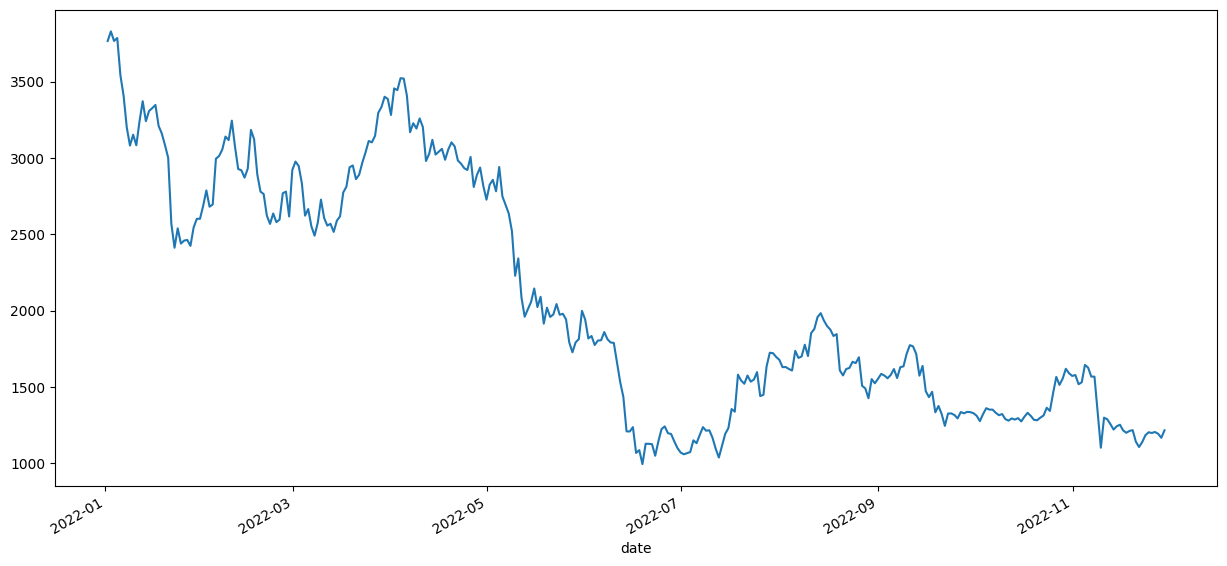

In [22]:
# Searching outliers in the dataframe
eth['close'].plot(figsize=(15,7))

In [23]:
# I will need to merge the data of btc and eth, but before I must verify if the indexes are the same in both df
k = 0
for v in btc.index:
    if eth.index[k] != btc.index[k]:
        print('Not the same')
    k += 1

In [24]:
# Merging the df
cryptos = pd.merge(btc, eth, left_index=True, right_index=True)

In [25]:
cryptos.head()

,open_x,high_x,low_x,close_x,volume_x,qt_volume_x,open_y,high_y,low_y,close_y,volume_y,qt_volume_y
date,,,,,,,,,,,,
2022-01-01 21:00:00,46216.93,47954.63,46208.37,47722.65,19604.46325,9.241552e+08,3676.22,3776.45,3673.46,3765.54,154143.8968,5.747183e+08
2022-01-02 21:00:00,47722.66,47990.00,46654.00,47286.18,18340.46040,8.666110e+08,3765.54,3857.44,3717.30,3828.27,154791.4263,5.853750e+08
2022-01-03 21:00:00,47286.18,47570.00,45696.00,46446.10,27662.07710,1.292204e+09,3828.11,3853.09,3680.00,3765.89,236245.8586,8.929441e+08
2022-01-04 21:00:00,46446.10,47557.54,45500.00,45832.01,35491.41360,1.649170e+09,3765.89,3900.73,3713.11,3785.11,288258.5549,1.098183e+09
2022-01-05 21:00:00,45832.01,47070.00,42500.00,43451.13,51784.11857,2.334289e+09,3785.10,3848.00,3415.00,3540.63,397942.0363,1.464819e+09


In [29]:
# Changing the columns names
cryptos = cryptos.rename(columns={'open_x':'OpenPrice_btc', 'high_x':'HighPrice_btc', 'low_x':'LowPrice_btc', 'close_x':'ClosePrice_btc', 
                                  'volume_x':'Volume_btc', 'qt_volume_x': 'QtVolume_btc'})

In [30]:
cryptos.head()

,OpenPrice_btc,HighPrice_btc,LowPrice_btc,ClosePrice_btc,Volume_btc,QtVolume_btc,open_y,high_y,low_y,close_y,volume_y,qt_volume_y
date,,,,,,,,,,,,
2022-01-01 21:00:00,46216.93,47954.63,46208.37,47722.65,19604.46325,9.241552e+08,3676.22,3776.45,3673.46,3765.54,154143.8968,5.747183e+08
2022-01-02 21:00:00,47722.66,47990.00,46654.00,47286.18,18340.46040,8.666110e+08,3765.54,3857.44,3717.30,3828.27,154791.4263,5.853750e+08
2022-01-03 21:00:00,47286.18,47570.00,45696.00,46446.10,27662.07710,1.292204e+09,3828.11,3853.09,3680.00,3765.89,236245.8586,8.929441e+08
2022-01-04 21:00:00,46446.10,47557.54,45500.00,45832.01,35491.41360,1.649170e+09,3765.89,3900.73,3713.11,3785.11,288258.5549,1.098183e+09
2022-01-05 21:00:00,45832.01,47070.00,42500.00,43451.13,51784.11857,2.334289e+09,3785.10,3848.00,3415.00,3540.63,397942.0363,1.464819e+09


In [31]:
cryptos = cryptos.rename(columns={'open_y':'OpenPrice_eth', 'high_y':'HighPrice_eth', 'low_y':'LowPrice_eth', 'close_y':'ClosePrice_eth', 
                                  'Volume_y':'Volume_eth', 'qt_volume_y':'QtVolume_eth'})

In [32]:
cryptos.head()

,OpenPrice_btc,HighPrice_btc,LowPrice_btc,ClosePrice_btc,Volume_btc,QtVolume_btc,OpenPrice_eth,HighPrice_eth,LowPrice_eth,ClosePrice_eth,volume_y,QtVolume_eth
date,,,,,,,,,,,,
2022-01-01 21:00:00,46216.93,47954.63,46208.37,47722.65,19604.46325,9.241552e+08,3676.22,3776.45,3673.46,3765.54,154143.8968,5.747183e+08
2022-01-02 21:00:00,47722.66,47990.00,46654.00,47286.18,18340.46040,8.666110e+08,3765.54,3857.44,3717.30,3828.27,154791.4263,5.853750e+08
2022-01-03 21:00:00,47286.18,47570.00,45696.00,46446.10,27662.07710,1.292204e+09,3828.11,3853.09,3680.00,3765.89,236245.8586,8.929441e+08
2022-01-04 21:00:00,46446.10,47557.54,45500.00,45832.01,35491.41360,1.649170e+09,3765.89,3900.73,3713.11,3785.11,288258.5549,1.098183e+09
2022-01-05 21:00:00,45832.01,47070.00,42500.00,43451.13,51784.11857,2.334289e+09,3785.10,3848.00,3415.00,3540.63,397942.0363,1.464819e+09


In [33]:
cryptos.describe()

,OpenPrice_btc,HighPrice_btc,LowPrice_btc,ClosePrice_btc,Volume_btc,QtVolume_btc,OpenPrice_eth,HighPrice_eth,LowPrice_eth,ClosePrice_eth,volume_y,QtVolume_eth
count,333.000000,333.000000,333.000000,333.000000,333.000000,3.330000e+02,333.000000,333.000000,333.000000,333.000000,3.330000e+02,3.330000e+02
mean,29354.399309,30025.544985,28554.610871,29265.009550,142136.966905,3.289248e+09,2065.994144,2128.538168,1992.577748,2058.616006,7.417493e+05,1.350657e+09
std,10041.164921,10263.973538,9794.846982,10023.112339,125247.115050,2.210450e+09,777.222391,792.579055,756.612837,773.561155,4.830265e+05,6.762782e+08
min,15781.290000,16315.000000,15476.000000,15781.290000,15805.447180,6.161947e+08,995.120000,1078.880000,881.560000,995.130000,1.541439e+05,2.455478e+08
25%,20173.620000,20576.250000,19652.720000,20158.260000,46275.669120,1.711653e+09,1336.170000,1373.190000,1306.520000,1335.700000,4.213914e+05,8.893249e+08
50%,24305.250000,24918.540000,23773.220000,24094.820000,91904.753211,2.556533e+09,1791.880000,1827.400000,1722.260000,1788.810000,5.782128e+05,1.276328e+09
75%,39530.450000,40444.320000,38536.510000,39450.130000,210509.495450,4.294908e+09,2817.130000,2943.970000,2746.420000,2811.920000,9.355315e+05,1.634901e+09
max,47722.660000,48189.840000,46950.850000,47722.650000,760705.362783,1.475838e+10,3828.110000,3900.730000,3717.300000,3828.270000,3.626352e+06,4.611744e+09


In [34]:
cryptos.isnull().values.any()

False

In [35]:
# Creating a model of the linear regression

# Creating the variables
y = cryptos['ClosePrice_btc'].tolist()
x = cryptos['ClosePrice_eth'].tolist()

# Adding the constant term
x = sm.add_constant(x)

# Performing the regression and fitting the model
result = sm.OLS(y, x).fit()

# Printing the sumary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     6179.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          3.48e-216
Time:                        14:24:53   Log-Likelihood:                -3043.8
No. Observations:                 333   AIC:                             6092.
Df Residuals:                     331   BIC:                             6099.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3278.3087    353.108      9.284      0.0

# Interpretation
### For each dolar added in the price of ethereum, the price of the bitcoin rises $12.6234.

# Measuring the goodness of fit
### 94.9% of variations in Y variable can be explained by our X variable.

# Hypothesis testing
### We can see that in both variables the t value is, in module, bigger than 2 and the p-value is also less than 0.05. So, we can reject the null hypothesis of the predictor. This mean that the price of ethereum have a statistically significant relationship between final exam score. And, as we can see, the p-value in the f-statisc is small, so we can reject the null global hypothesis.

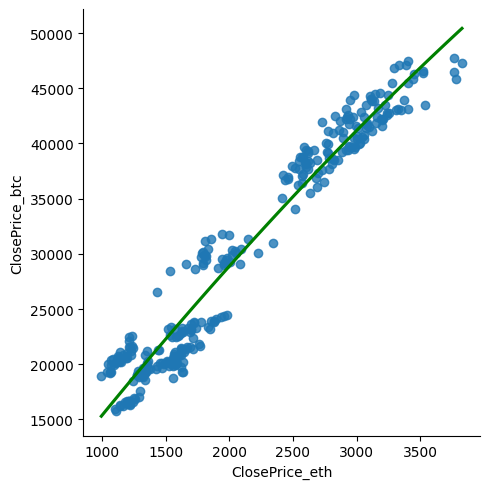

In [40]:
# Plotting the chart
sns.lmplot(x = 'ClosePrice_eth', y = 'ClosePrice_btc', data= cryptos, order = 2, ci = None, line_kws={'color':'green'})

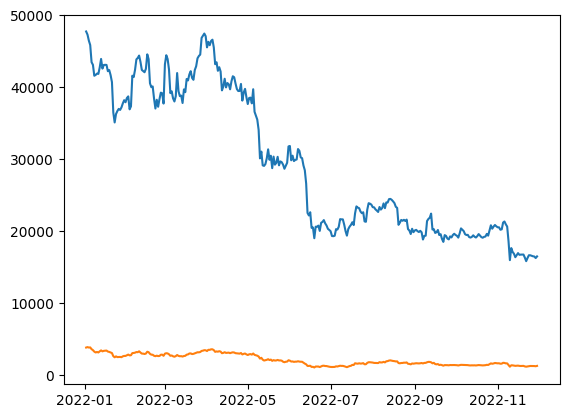

In [43]:
# Checking the movements of the two close's prices together
plt.plot(cryptos.index, cryptos['ClosePrice_btc'])
plt.plot(cryptos.index, cryptos['ClosePrice_eth'])
plt.show()

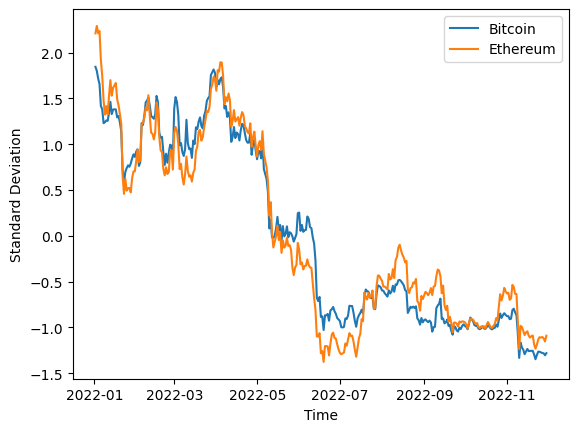

In [86]:
# Checking the standard deviation between time
plt.plot(cryptos.index, scale(cryptos['ClosePrice_btc']), label='Bitcoin')
plt.plot(cryptos.index, scale(cryptos['ClosePrice_eth']), label='Ethereum')
plt.legend()
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.show()

Text(0.5, 0, 'Residuals')

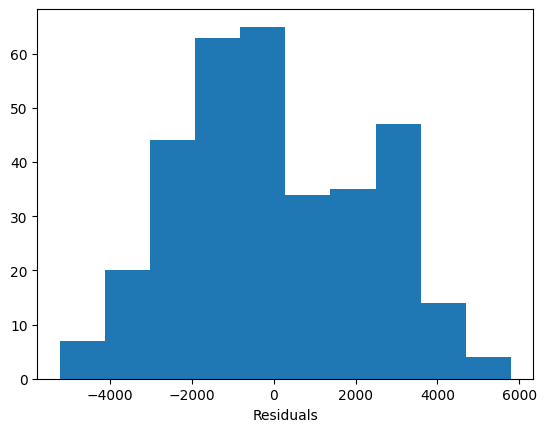

In [44]:
# Plotting and analysing the resicuals
res_hist = plt.hist(result.resid)
plt.xlabel('Residuals')

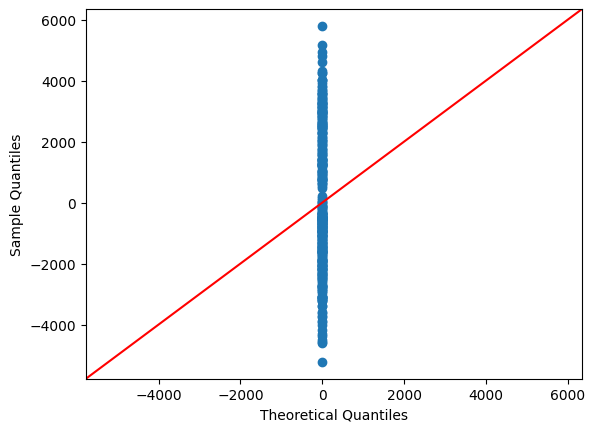

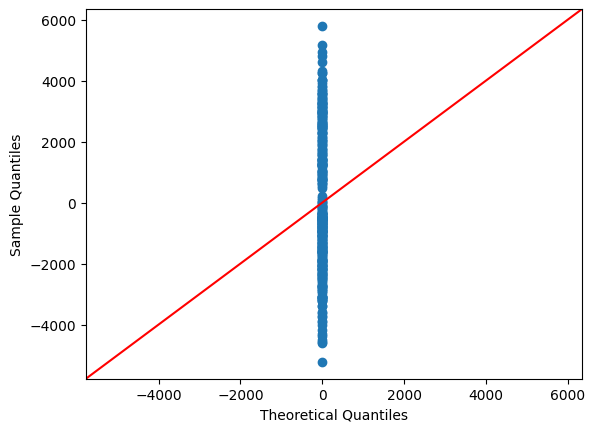

In [49]:
sm.qqplot(result.resid, line='45')

# Perform a Shapiro-Wilk Test

In [50]:
shapiro(result.resid)

ShapiroResult(statistic=0.9746242165565491, pvalue=1.3360917364479974e-05)

### From the output we can see that the test statisc is 0.974 and the corresponding p-value is 1.3360917364479974e-05.
### Since the p-value is less than 0.05, we can reject the null hypothesis of the Shapiro_Wilk test.
### This means we have suffcient evidence to say that the sample data does not come from a normal distribution.

# Multicollinearity

In [54]:
# Testeing the multicollinearity

# Find design matrix for regression model

y, X = dmatrices('ClosePrice_btc ~ ClosePrice_eth', data=cryptos, return_type='dataframe')

# Create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns

# Calculate VIF for each predictor variable
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# View VIF for predictor variable
print(vif_df)

         variable       VIF
0       Intercept  8.103421
1  ClosePrice_eth  1.000000


### Since the value of the predictor variable in the model is 1, there is not multicollinearity.

# Heteroscedasticity

In [58]:
# Heteroscedasticity test
keys = ['Lagrange Multiplier Statisc:', 'LM test\'sp-value:', 'F-statisc:', 'F-test\'s p-value:']

results = het_white(result.resid, X)

lzip(keys, results)

[('Lagrange Multiplier Statisc:', 4.389279852735297),
 ("LM test'sp-value:", 0.11139866600650061),
 ('F-statisc:', 2.203918287804991),
 ("F-test's p-value:", 0.11199185877558926)]

### As the both p-values are bigger than .05, we can not reject the null hypothesis of heteroscedasticity.

# Residuals autocorrelation

In [62]:
# Testing if the resilduals os the regression model are autocorrelated
durbin_watson(result.resid)

0.05508438257291179

### As the result is bigger than .05, we can not reject the null hypothesis of the autocorrelation between the residuals.

(array([20.,  8., 72., 37., 23., 10.,  1.,  1., 22., 10.,  1.,  1.,  5.,
        17., 27., 17., 27., 19.,  5., 10.]),
 array([15781.29 , 17378.358, 18975.426, 20572.494, 22169.562, 23766.63 ,
        25363.698, 26960.766, 28557.834, 30154.902, 31751.97 , 33349.038,
        34946.106, 36543.174, 38140.242, 39737.31 , 41334.378, 42931.446,
        44528.514, 46125.582, 47722.65 ]),
 <BarContainer object of 20 artists>)

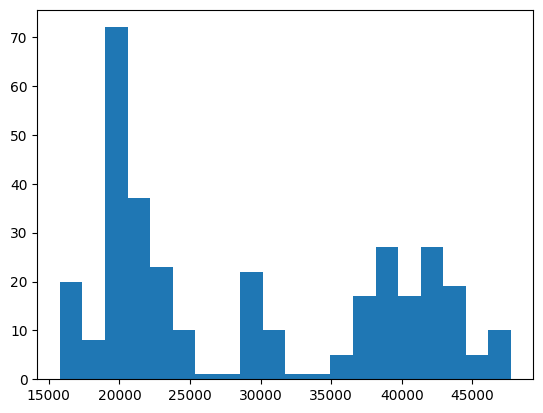

In [66]:
# Verifing if there is a normal distribution in the close's prices
plt.hist(cryptos['ClosePrice_btc'], bins=20)

(array([18., 37., 39., 24., 38., 21., 17.,  8.,  2.,  1., 11., 21., 16.,
        20., 24., 16.,  9.,  7.,  0.,  4.]),
 array([ 995.13 , 1136.787, 1278.444, 1420.101, 1561.758, 1703.415,
        1845.072, 1986.729, 2128.386, 2270.043, 2411.7  , 2553.357,
        2695.014, 2836.671, 2978.328, 3119.985, 3261.642, 3403.299,
        3544.956, 3686.613, 3828.27 ]),
 <BarContainer object of 20 artists>)

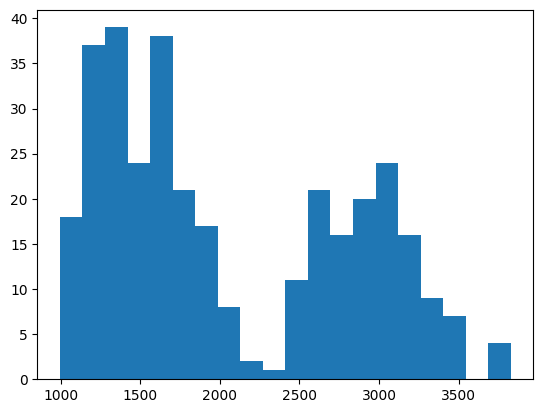

In [67]:
plt.hist(cryptos['ClosePrice_eth'], bins=20)